In [1]:
import pandas as pd
import sklearn
import torch
from sklearn.model_selection import train_test_split
from torch.nn.functional import one_hot
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
url =  'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower',
               'Weight', 'Acceleration', 'Model Year', 'Origin']
df = pd.read_csv(url, names=column_names, na_values = "?", comment='\t', sep=" ", skipinitialspace=True)
print(df.head(5))

    MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
0  18.0          8         307.0       130.0  3504.0          12.0   
1  15.0          8         350.0       165.0  3693.0          11.5   
2  18.0          8         318.0       150.0  3436.0          11.0   
3  16.0          8         304.0       150.0  3433.0          12.0   
4  17.0          8         302.0       140.0  3449.0          10.5   

   Model Year  Origin  
0          70       1  
1          70       1  
2          70       1  
3          70       1  
4          70       1  


In [3]:
df = df.dropna()
df = df.reset_index(drop=True)
df.head(5)

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [4]:
df_train, df_test = train_test_split(df, train_size=0.8, random_state=42)
print(df_train.head(5))

      MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
258  18.6          6         225.0       110.0  3620.0          18.7   
182  25.0          4         140.0        92.0  2572.0          14.9   
172  18.0          6         171.0        97.0  2984.0          14.5   
63   15.0          8         318.0       150.0  4135.0          13.5   
340  39.0          4          86.0        64.0  1875.0          16.4   

     Model Year  Origin  
258          78       1  
182          76       1  
172          75       1  
63           72       1  
340          81       1  


In [5]:
train_stats = df_train.describe().transpose()
print(train_stats)

              count         mean         std     min     25%     50%     75%  \
MPG           313.0    23.599361    7.956255     9.0    17.0    23.0    30.0   
Cylinders     313.0     5.482428    1.700446     3.0     4.0     4.0     8.0   
Displacement  313.0   195.517572  103.766567    70.0   105.0   151.0   302.0   
Horsepower    313.0   104.594249   38.283669    46.0    76.0    95.0   129.0   
Weight        313.0  2986.124601  841.133957  1613.0  2234.0  2855.0  3645.0   
Acceleration  313.0    15.544089    2.817864     8.0    13.5    15.5    17.3   
Model Year    313.0    76.207668    3.630136    70.0    73.0    76.0    79.0   
Origin        313.0     1.555911    0.807163     1.0     1.0     1.0     2.0   

                 max  
MPG             46.6  
Cylinders        8.0  
Displacement   455.0  
Horsepower     230.0  
Weight        5140.0  
Acceleration    24.8  
Model Year      82.0  
Origin           3.0  


In [6]:
numeric_column_names = ['Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration']

df_train_norm, df_test_norm = df_train.copy(), df_test.copy()
for col_name in numeric_column_names:
  mean = train_stats.loc[col_name, 'mean']
  std = train_stats.loc[col_name, 'std']
  df_train_norm.loc[:, col_name] = (df_train_norm.loc[:, col_name] - mean)/std
  df_test_norm.loc[:, col_name] = (df_test_norm.loc[:, col_name] - mean)/std

print(df_train_norm.head(5))

      MPG  Cylinders  Displacement  Horsepower    Weight  Acceleration  \
258  18.6   0.304374      0.284123    0.141203  0.753596      1.119966   
182  25.0  -0.871788     -0.535024   -0.328972 -0.492341     -0.228574   
172  18.0   0.304374     -0.236276   -0.198368 -0.002526     -0.370525   
63   15.0   1.480536      1.180365    1.186034  1.365865     -0.725404   
340  39.0  -0.871788     -1.055423   -1.060354 -1.320984      0.303744   

     Model Year  Origin  
258          78       1  
182          76       1  
172          75       1  
63           72       1  
340          81       1  


In [7]:
boundaries = torch.tensor([73, 76, 79])
v = torch.tensor(df_train_norm['Model Year'].values)
df_train_norm['Model Year Bucketed'] = torch.bucketize(
    v, boundaries, right=True)
v = torch.tensor(df_test_norm['Model Year'].values)
df_test_norm['Model Year Bucketed'] = torch.bucketize(
    v, boundaries, right=True)
numeric_column_names.append('Model Year Bucketed')

print(df_train_norm.head(5))

      MPG  Cylinders  Displacement  Horsepower    Weight  Acceleration  \
258  18.6   0.304374      0.284123    0.141203  0.753596      1.119966   
182  25.0  -0.871788     -0.535024   -0.328972 -0.492341     -0.228574   
172  18.0   0.304374     -0.236276   -0.198368 -0.002526     -0.370525   
63   15.0   1.480536      1.180365    1.186034  1.365865     -0.725404   
340  39.0  -0.871788     -1.055423   -1.060354 -1.320984      0.303744   

     Model Year  Origin  Model Year Bucketed  
258          78       1                    2  
182          76       1                    2  
172          75       1                    1  
63           72       1                    0  
340          81       1                    3  


In [8]:
total_origin = len(set(df_train_norm['Origin']))
origin_encoded = one_hot(torch.from_numpy(df_train_norm['Origin'].values) % total_origin)

x_train_numeric = torch.tensor(df_train_norm[numeric_column_names].values)
x_train = torch.cat([x_train_numeric, origin_encoded], 1).float()

origin_encoded = one_hot(torch.from_numpy(df_test_norm['Origin'].values) % total_origin)

x_test_numeric = torch.tensor(df_test_norm[numeric_column_names].values)
x_test = torch.cat([x_test_numeric, origin_encoded], 1).float()

In [9]:
y_train = torch.tensor(df_train_norm['MPG'].values).float()
y_test = torch.tensor(df_test_norm['MPG'].values).float()

In [10]:
train_dataset = TensorDataset(x_train, y_train)
batch_size = 8
torch.manual_seed(1)
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)

In [11]:
hidden_units = [8, 4]
input_size = x_train.shape[1]
all_layers = []
for hidden_unit in hidden_units:
  layer = nn.Linear(input_size, hidden_unit)
  all_layers.append(layer)
  all_layers.append(nn.ReLU())
  input_size = hidden_unit

all_layers.append(nn.Linear(hidden_units[-1], 1))
model = nn.Sequential(*all_layers)
print(model)

Sequential(
  (0): Linear(in_features=9, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=4, bias=True)
  (3): ReLU()
  (4): Linear(in_features=4, out_features=1, bias=True)
)


In [12]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [13]:
torch.manual_seed(1)
num_epochs = 200
log_epochs = 20

loss_hist_train = [0] * num_epochs

for epoch in range(num_epochs):
  for x_batch, y_batch in train_dataloader:
    pred = model(x_batch)[:, 0]
    loss = loss_fn(pred, y_batch)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    loss_hist_train[epoch] += loss.item()

  if epoch % log_epochs == 0:
    print(f'Epoch {epoch} Loss ' f'{loss_hist_train[epoch]/len(train_dataloader):.4f}')

loss_hist_train = [loss / len(train_dataloader) for loss in loss_hist_train]

Epoch 0 Loss 539.9970
Epoch 20 Loss 8.5615
Epoch 40 Loss 9.5788
Epoch 60 Loss 8.4521
Epoch 80 Loss 9.2728
Epoch 100 Loss 10.8870
Epoch 120 Loss 7.9455
Epoch 140 Loss 8.7864
Epoch 160 Loss 8.1935
Epoch 180 Loss 8.2191


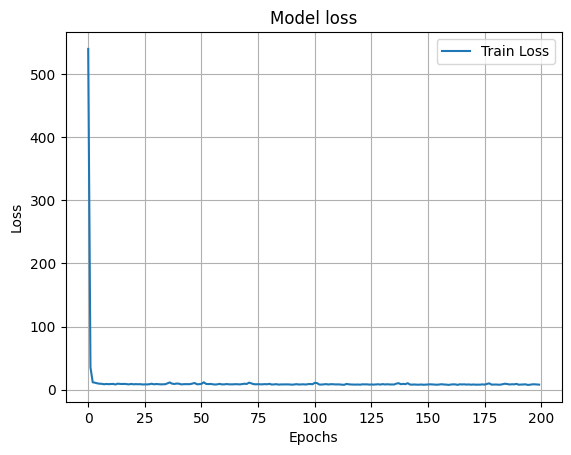

In [14]:
fig1 = plt.gcf()

plt.plot(loss_hist_train)
plt.grid()
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train Loss'])
plt.show()

In [15]:
with torch.no_grad():
  pred - model(x_test.float())[:, 0]
  loss = loss_fn(pred, y_test)
  print(f'Test MSE: {loss.item():.4f}')
  print(f'Test MAE: {nn.L1Loss()(pred, y_test).item():.4f}')

Test MSE: 55.3239
Test MAE: 5.9275


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([79])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([79])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
